In [1]:
from f_train import *
from f_drosophila_infer import *
from f_data_prep import *
import seaborn as sns
from sklearn import linear_model

In [2]:
data_all = np.loadtxt('../data_complete.txt')
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

def make_quad(X):
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = X.shape[1]
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    return quad

with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)
    
val = np.hstack([cells_v+(6078*i) for i in range(5)])
cells_tt = np.delete(range(6078), cells_v)
tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])

X_init = all_init[val]
# quad_v = quad[val]
quad_v = make_quad(X_init)
y_v = all_diff[val]

In [3]:
w = np.zeros((4950,99))
bias = np.zeros(99)
for k in range(990):
    i = int(k/10)
    with open('./pickles/res/res_%s.pkl' % k, 'rb') as f:
        res = pickle.load(f)
    w[:,i:(i+1)] += res[0]
    bias[i] += res[1]
w = w/10
bias = bias/10

yp = X_init + bias + quad_v.dot(w)
ya = X_init + y_v
yp[yp < 0] = 0

ferror = np.sum(np.abs(yp - ya), axis=0)/np.sum(np.abs(ya), axis=0)
error1 = np.abs(yp - ya)

dic = {
    'ferror': ferror,
    'error': error1,
    'w': w,
    'bias': bias
}

# with open('./pickles/LAD_(99,99)_ttv.pkl', 'wb') as f:
#     pickle.dump(dic, f)

In [11]:
print(len(yp[yp<0])/yp.size, np.quantile(yp[yp<0], 0.02), np.min(yp))

0.005462519936204147 -0.07492750048097141 -0.12346127346259575


In [4]:
with open('./pickles/validation_cells.pkl', 'rb') as f:
    cells_v = pickle.load(f)

In [7]:
def skl_cv_quad_cellselect(X, y, kf=10):
    kfold = KFold(n_splits=kf, shuffle=False)
    
    quad = np.zeros((int(X.shape[0]), int(X.shape[1] + (X.shape[1]*(X.shape[1]-1))/2)))
    quad[:, :X.shape[1]] = np.copy(X)
    col = 99
    for i in range(X.shape[1]-1):
        for j in range(i+1, X.shape[1]):
            quad[:,col] = (X[:,i]*X[:,j])
            col += 1
    
    val = np.hstack([cells_v+(6078*i) for i in range(5)])
    cells_tt = np.delete(range(6078), cells_v)
    tr_te = np.hstack([cells_tt+(6078*i) for i in range(5)])
    
    X_v = X[val]
    quad_v = quad[val]
    y_v = y[val]
    quad_tt = quad[tr_te]
    y_tt = y[tr_te]
    
    regr=linear_model.LinearRegression()
    regr.fit(quad_tt, y_tt)
    w = regr.coef_
    bias = regr.intercept_
    
    print(w.shape, bias.shape)
    
    yp = X_v + bias + quad_v.dot(w.T)
    yp[yp<0] = 0
    ya = X_v + y_v
    ferror = (np.sum(np.abs(yp - ya)**2, axis=0)/np.sum(np.abs(ya)**2, axis=0))**(1/2)
    error1 = np.abs(yp - ya)
    
    dic = {
        'ferror': ferror,
        'error': error1,
        'w': w,
        'bias': bias
    }
    return dic

# results = skl_cv_quad_cellselect(all_init, all_diff, kf=10)

# with open('./pickles/skl_(99,99)_tv.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [8]:
with open('./pickles/LAD_(99,99)_ttv.pkl', 'rb') as f:
    LAD = pickle.load(f)

with open('./pickles/skl_(99,99)_tv.pkl', 'rb') as f:
    skl = pickle.load(f)

MannwhitneyuResult(statistic=4319512.0, pvalue=5.347707579246956e-06)
MannwhitneyuResult(statistic=4491146.0, pvalue=0.02907379195604959)


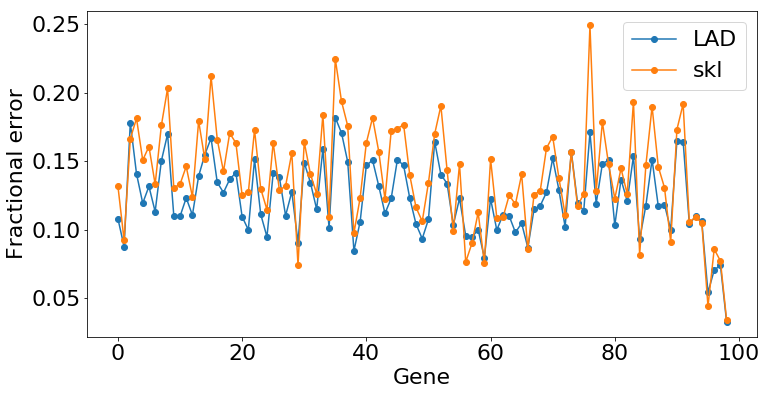

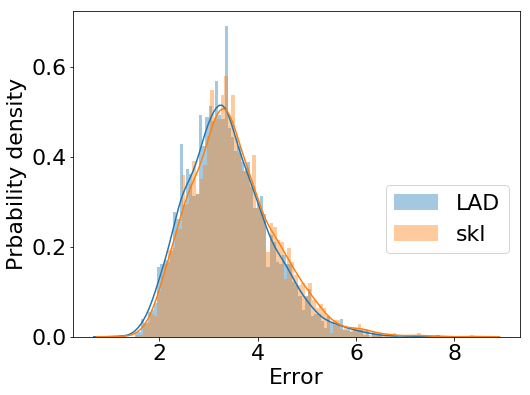

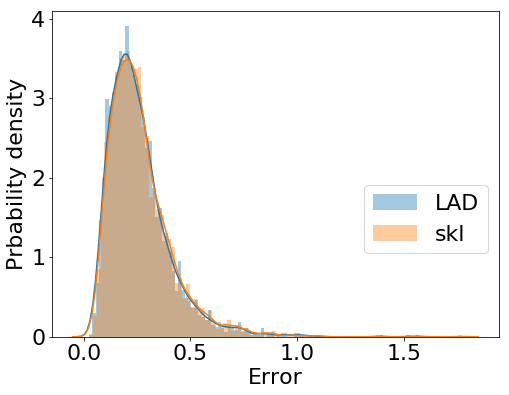

In [9]:
matplotlib.rcParams.update({'font.size':22})
plt.figure(figsize=(12,6))
plt.plot(range(len(LAD['ferror'])), LAD['ferror'], 'o-', label='LAD')
plt.plot(range(len(skl['ferror'])), skl['ferror'], 'o-', label='skl')
plt.xlabel('Gene')
plt.ylabel('Fractional error')
plt.legend(loc='best')

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD['error'], axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl['error'], axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl, alternative='less'))

plt.figure(figsize=(8,6))
error_lad = np.sum(LAD['error']**2, axis=1)
sns.distplot(error_lad, bins=100, label='LAD')
error_skl = np.sum(skl['error']**2, axis=1)
sns.distplot(error_skl, bins=100, label='skl')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xlabel('Error')
plt.ylabel('Prbability density')

print(stats.mannwhitneyu(error_lad, error_skl, alternative='less'))

In [8]:
w = LAD['w']
quad = make_quad(all_init)
ranges = np.abs(np.max(quad, axis=0) - np.min(quad, axis=0))

In [9]:
effects = np.multiply(np.abs(w), ranges[:,None])
np.fill_diagonal(effects, 0)
effects_sum = np.sum(effects, axis=1)

In [10]:
with open('./pickles/names.pkl', 'rb') as f:
    names = pickle.load(f)

In [11]:
print(np.argmin(effects_sum[:99]), effects_sum[:99][np.argmin(effects_sum[:99])])
print(np.argmax(effects_sum[:99]), effects_sum[:99][np.argmax(effects_sum[:99])])

85 9.246376330311897
89 38.804453170783425


In [12]:
quad_gene = []
for i in range(98):
    for j in range(i+1,99):
        quad_gene.append([i,j])

print(quad_gene[np.argmin(effects_sum[99:])], effects_sum[99:][np.argmin(effects_sum[99:])])
print(quad_gene[np.argmax(effects_sum[99:])], effects_sum[99:][np.argmax(effects_sum[99:])])

[8, 79] 2.1244795295984034
[56, 76] 42.94129532424947


In [13]:
# init = np.copy(all_bin[0])
# w = LAD['w']
# bias = LAD['bias']
# for i in range(5):
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
# #     init[init < 0] = 0
#     print(np.min(init))
# # gene[gene < 0] = 0
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)/np.sum(np.abs(all_bin[5]), axis=0)
# plt.figure(figsize=(12,6))
# plt.plot(range(99), error_t, 'o-')

# init = np.copy(all_bin[0])
# w = LAD['w']
# bias = LAD['bias']
# for i in range(5):
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
#     init[init < 0] = 0
# gene[gene < 0] = 0
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)/np.sum(np.abs(all_bin[5]), axis=0)
# # plt.figure(figsize=(12,6))
# plt.plot(range(99), error_t, 'ro-')
# plt.show()

# gene_list = np.argsort(error_t)
# non_comp_ind = [i for i in range(99) if i not in comp_ind]
# for gene_ind in [94]:
#     plt.figure(figsize=(12,6))
# #     print(gene_ind)
#     for j in range(5):
#         init = np.copy(all_bin[0])
#         for i in range(5):
#             if i == j:
#                 init[:,gene_ind] = 0
#             quad = make_quad(init)
#             gene = init + bias + quad.dot(w)
#             init = gene
#             init[init < 0] = 0
#         error = np.sum(np.abs(gene - all_bin[5]), axis=0)
#         print(j, np.median(error/error_t), np.mean(error/error_t))
#         plt.plot(range(99), error/error_t, 'o-', alpha=0.7, label = 'timepoint=%s' % (j))
#         plt.title('gene %s knockout' % gene_ind)

#     plt.legend(bbox_to_anchor=(1,1))
#     plt.show()

In [14]:
# raw_data = np.loadtxt('../dmel_data.txt').T
# xyz = raw_data[:,:3]
# xlabels = ['x', 'y', 'z']

# w = LAD['w']
# bias = LAD['bias']
# for gene_i in gene_list:
#     fig = plt.figure(figsize=(16,6))
#     ax1 = fig.add_subplot(121)
#     xy = ax1.scatter(xyz[:,0], xyz[:,2], c=all_bin[5][:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#     plt.colorbar(xy, ax=ax1)
#     plt.title('observed gene %s' % gene_i)
    
#     init = np.copy(all_bin[0])
#     for i in range(5):
#         quad = make_quad(init)
#         gene = init + bias + quad.dot(w)
#         init = gene
#         init[init < 0] = 0
#     gene[gene < 0] = 0
#     ax2 = fig.add_subplot(122)
#     ax2.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#     plt.colorbar(xy, ax=ax2)
#     plt.title('simulated gene %s' % gene_i)
#     #         plt.title('gene %s knockout' % gene_ind)

#     #     plt.legend(bbox_to_anchor=(1,1))
#     plt.show()

# $\dfrac{\sum |\text{obs} - \text{knockout}|}{\sum |\text{obs} - \text{w/o knockout}|}$

In [15]:
# w = LAD['w']
# bias = LAD['bias']
# gene_ind = 89
# init = np.copy(all_bin[0])
# for i in range(5):
# #             init[init < 0] = 0
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
# #         gene[gene < 0] = 0
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)
# fig = plt.figure(figsize=(16,20))
# fig_ind=1
# for (i,j) in combinations(range(6), 2):
#     init = np.copy(all_bin[0])
#     k_ind = 0
#     for k in range(5):
#         if k >= i and k < j:
#             init[:, gene_ind] = 0
# #                 init[init < 0] = 0
#         quad = make_quad(init)
#         gene = init + bias + quad.dot(w)
#         init = gene
#         if len(gene[gene < -0.2]) > 0:
#             k_ind = k
#             if k_ind > k:
                
# #             gene[gene < 0] = 0
#     error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
#     ax = fig.add_subplot(5,3,fig_ind)
#     ax.plot(range(99), error, 'o-')
#     plt.title('gene %s knockout for [%s, %s)' % (gene_ind, i, j), fontsize=12)
#     fig_ind += 1
# plt.show()

# w = LAD['w']
# bias = LAD['bias']
# gene_ind = 89
# init = np.copy(all_bin[0])
# for i in range(5):
# #             init[init < 0] = 0
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
# #         gene[gene < 0] = 0
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)
# fig = plt.figure(figsize=(16,20))
# fig_ind=1
# for (i,j) in combinations(range(6), 2):
#     init = np.copy(all_bin[0])
#     for k in range(5):
#         if k >= i and k < j:
#             init[:, gene_ind] = 0
#         init[init < 0] = 0
#         quad = make_quad(init)
#         gene = init + bias + quad.dot(w)
#         init = gene
#         gene[gene < 0] = 0
#     error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
#     ax = fig.add_subplot(5,3,fig_ind)
#     ax.plot(range(99), error, 'o-')
#     plt.title('gene %s knockout for [%s, %s)' % (gene_ind, i, j), fontsize=12)
#     fig_ind += 1
# plt.show()

In [22]:
init = np.copy(all_bin[0])
w = LAD['w']
bias = LAD['bias']
for i in range(5):
    quad = make_quad(init)
    gene = init + bias + quad.dot(w)
    init = gene
#     init[init < 0] = 0
    print(np.min(init))

-0.15509210647332158
-0.1654915114728765
-0.19602200761760716
-0.22953393593506158
-0.4233101579617131


In [17]:
# from itertools import combinations

# raw_data = np.loadtxt('../dmel_data.txt').T
# xyz = raw_data[:,:3]
# xlabels = ['x', 'y', 'z']

# # gene_list = [98,95,8,92,97,56,21,61,58,66,96,0,9,39,29,73,71,37,3,33,75,81,77]

# w = LAD['w']
# bias = LAD['bias']
# for gene_i in [98]:
#     effector_list = np.argsort(effects[:,gene_i])[-1]
#     for (index, effector) in enumerate(effector_list[::-1]):
#         if effector > 98:
#             gene_ind = (quad_gene[effector-99])
#         else:
#             gene_ind = effector
#         print(gene_ind)
    
#         fig = plt.figure(figsize=(16,14))
#         ax1 = fig.add_subplot(2,2,1)
#         xy = ax1.scatter(xyz[:,0], xyz[:,2], c=all_bin[5][:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#         plt.colorbar(xy, ax=ax1)
#         plt.title('observed gene %s' % gene_i)

#         init = np.copy(all_bin[0])
#         for i in range(5):
#             init[init < 0] = 0
#             quad = make_quad(init)
#             gene = init + bias + quad.dot(w)
#             init = gene
#         gene[gene < 0] = 0
#         ax2 = fig.add_subplot(2,2,2)
#         ax2.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#         plt.colorbar(xy, ax=ax2)
#         plt.title('simulated gene %s' % gene_i)
#         error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)

#         error_list = []
#         for (i,j) in combinations(range(6), 2):
#             init = np.copy(all_bin[0])
#             for k in range(5):
#                 if k >= i and k < j:
#                     init[:, gene_ind] = 0
#                 init[init < 0] = 0
#                 quad = make_quad(init)
#                 gene = init + bias + quad.dot(w)
#                 init = gene
#             gene[gene < 0] = 0
#             error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
#             error_list.append([i,j,error[gene_i]])
#         ind = np.argmax([error_list[n][2] for n in range(15)])
#         print(error_list[ind])
#         i,j = error_list[ind][:2]
#         init = np.copy(all_bin[0])
#         for k in range(5):
#             if k >= i and k < j:
#                 init[:, gene_ind] = 0
#             init[init < 0] = 0
#             quad = make_quad(init)
#             gene = init + bias + quad.dot(w)
#             init = gene
#         gene[gene < 0] = 0
#         ax3 = fig.add_subplot(2,2,3)
#         ax3.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#         plt.colorbar(xy, ax=ax3)
#         plt.title('simulated gene %s with gene %s knockout for [%s,%s)' % (gene_i, gene_ind, i,j), fontsize=16)

#         ind = np.argmin([error_list[n][2] for n in range(15)])
#         print(error_list[ind])
#         i,j = error_list[ind][:2]
#         init = np.copy(all_bin[0])
#         for k in range(5):
#             if k >= i and k < j:
#                 init[:, gene_ind] = 0
#             init[init < 0] = 0
#             quad = make_quad(init)
#             gene = init + bias + quad.dot(w)
#             init = gene
#         gene[gene < 0] = 0
#         ax4 = fig.add_subplot(2,2,4)
#         ax4.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#         plt.colorbar(xy, ax=ax4)
#         plt.title('simulated gene %s with gene %s knockout for [%s,%s)' % (gene_i, gene_ind, i,j), fontsize=16)
# #         plt.savefig('./figures/gene%s_%s.pdf' % (gene_i, index), bbox_inches = 'tight')
#         plt.close()

In [18]:
# from itertools import combinations

# gene_ind = [13]
# init = np.copy(all_bin[0])
# w = LAD['w']
# bias = LAD['bias']
# for i in range(5):
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
#     init[init < 0] = 0
# gene[gene < 0] = 0
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)

# accu_error = np.zeros(99)
# for (i,j) in combinations(range(6), 2):
#     plt.figure(figsize=(12,6))
#     init = np.copy(all_bin[0])
#     print(i,j)
#     for k in range(5):
#         if k >= i and k < j:
#             init[:, gene_ind] = 0
#         init[init < 0] = 0
#         quad = make_quad(init)
#         gene = init + bias + quad.dot(w)
#         init = gene
#     gene[gene < 0] = 0
#     error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
#     print(np.argwhere(np.argsort(error) == 98))
#     print(error[98])
#     accu_error += error
#     plt.plot(range(99), error, 'o-')
#     plt.show()
    
        

In [19]:
# from itertools import combinations

# for gene_ind in range(99):
#     for (i,j) in combinations(range(6),2):
#         init = np.copy(all_bin[0])
#         for k in range(5):
#             if k >= i and k < j:
#                 init[:, gene_ind] = 0
#     #                 init[init < 0] = 0
#     #         for c in range(99):
#     #             std = np.std(init[:,c][init[:,c]>0])
#     #             for r in np.argwhere(init[:,c]):
#     #                 if np.abs(init[r,c]) < std:
#     #                     init[r,c] = 0
#             if len(np.argwhere(init < -0.2)) > 0:
# #                 print(i,j,k)
#                 print(gene_ind, i, j, k)
#                 break
#             quad = make_quad(init)
#             gene = init + bias + quad.dot(w)
#             init = gene
#             if k == 4:
#                 print(gene_ind,i,j)

In [20]:
# from itertools import combinations

# init = np.copy(all_bin[0])
# w = LAD['w']
# bias = LAD['bias']
# for i in range(5):
#     quad = make_quad(init)
#     gene = init + bias + quad.dot(w)
#     init = gene
# simulated = np.copy(gene)
# error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)

# for gene_ind in range(99):
#     for i in range(0,5):
#         k0 = 5
#         for j in range(i+1,6):
#             if j > k0:
#                 break
#             init = np.copy(all_bin[0])
#             for k in range(5):
#                 if k >= i and k < j:
#                     init[:, gene_ind] = 0
#                 if len(np.argwhere(init < -0.2)) > 0:
# #                     print(gene_ind, i, j, k)
#                     k0 = k
#                     break
#                 quad = make_quad(init)
#                 gene = init + bias + quad.dot(w)
#                 init = gene
#                 if k == 4 and len(np.argwhere(init < -0.4)) == 0:
#                     error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
#                     max_ind = np.argmax(error)
#                     if max_ind == gene_ind:
#                         max_ind = np.argsort(error)[-2]
#                     min_ind = np.argmin(error)
#                     print(gene_ind,i,j, error[max_ind], max_ind, error[min_ind], min_ind)
#                     for (index, gene_i) in enumerate([max_ind, min_ind]):
#                         fig = plt.figure(figsize=(16,14))
#                         ax1 = fig.add_subplot(2,2,1)
#                         xy = ax1.scatter(xyz[:,0], xyz[:,2], c=all_bin[5][:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#                         plt.colorbar(xy, ax=ax1)
#                         plt.title('observed gene %s' % gene_i)
                        
#                         ax2 = fig.add_subplot(2,2,2)
#                         ax2.scatter(xyz[:,0], xyz[:,2], c=simulated[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#                         plt.colorbar(xy, ax=ax2)
#                         plt.title('simulated gene %s' % gene_i)
                        
#                         ax3 = fig.add_subplot(2,2,3)
#                         ax3.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i].flatten(), s=15, cmap=plt.cm.PiYG)
#                         plt.colorbar(xy, ax=ax3)
#                         plt.title('simulated gene %s with gene %s knockout for [%s,%s)' % (gene_i, gene_ind, i,j), fontsize=16)
#                         plt.show()
    
#                     plt.figure(figsize=(12,6))
#                     plt.plot(range(99), error, 'o-')
#                     plt.show()

In [37]:
from itertools import combinations

raw_data = np.loadtxt('../dmel_data.txt').T
xyz = raw_data[:,:3]

with open('./pickles/names.pkl', 'rb') as f:
    gene_names = pickle.load(f)

with open('./pickles/train_cell_ind.pkl', 'rb') as f:
    train_cell_ind = pickle.load(f)
test_cell_ind = [ i for i in range(6078) if i not in set(list(train_cell_ind))]

xyz = np.copy(xyz[np.hstack((train_cell_ind, test_cell_ind)),:])

xlabels = ['x', 'y', 'z']

init = np.copy(all_bin[0])
w = LAD['w']
bias = LAD['bias']
for i in range(5):
    quad = make_quad(init)
    gene = init + bias + quad.dot(w)
    init = gene
simulated = np.copy(gene)
error_t = np.sum(np.abs(gene - all_bin[5]), axis=0)

gene_ind = [1,3,5,12,29,34,37,53,59]
for gene_ind in gene_ind:
    for i in range(0,5):
        k0 = 5
        for j in range(i+1,6):
            if j > k0:
                break
            init = np.copy(all_bin[0])
            for k in range(5):
                if k >= i and k < j:
                    init[:, gene_ind] = 0
                if len(np.argwhere(init < -0.3)) > 0:
#                     print(gene_ind, i, j, k)
                    k0 = k
                    break
                quad = make_quad(init)
                gene = init + bias + quad.dot(w)
                init = gene
                if k == 4 and len(np.argwhere(init < -0.43)) == 0:
                    error = np.sum(np.abs(gene - all_bin[5]), axis=0)/error_t
                    max_ind = np.argmax(error)
                    if max_ind == gene_ind:
                        max_ind = np.argsort(error)[-2]
                    min_ind = np.argmin(error)
                    print(gene_ind,i,j, error[max_ind], max_ind, error[min_ind], min_ind)
#                     for (index, gene_i) in enumerate([max_ind, min_ind]):
                    for gene_i in np.sort([97,26,95,84,65,9]):
                        norm = plt.Normalize(np.min([all_bin[5][:,gene_i],
                                                     simulated[:,gene_i],
                                                     gene[:,gene_i]]),
                                            np.max([all_bin[5][:,gene_i],
                                                     simulated[:,gene_i],
                                                     gene[:,gene_i]]))
                        fig = plt.figure(figsize=(20,5))
                        ax1 = fig.add_subplot(1,3,1)
                        xy = ax1.scatter(xyz[:,0], xyz[:,2], c=all_bin[5][:,gene_i], s=30, norm=norm, cmap=plt.cm.jet)
#                         plt.colorbar(xy, ax=ax1)
                        ax1.set_xlabel('x')
                        ax1.set_ylabel('z')
                        plt.title('observed $\mathit{%s}$' % gene_names[gene_i])
                        
                        ax2 = fig.add_subplot(1,3,2)
                        ax2.scatter(xyz[:,0], xyz[:,2], c=simulated[:,gene_i], s=30, norm=norm, cmap=plt.cm.jet)
#                         plt.colorbar(xy, ax=ax2)
                        ax2.set_xlabel('x')
                        plt.title('simulated $\mathit{%s}$' % gene_names[gene_i])
                        
                        ax3 = fig.add_subplot(1,3,3)
                        ax3.scatter(xyz[:,0], xyz[:,2], c=gene[:,gene_i], s=30, norm=norm, cmap=plt.cm.jet)
                        ax3.set_xlabel('x')
                        plt.title('simulated $\mathit{%s}$ with \n $\mathit{%s}$ KO for [%s,%s)' % (gene_names[gene_i], gene_names[gene_ind], i,j))
                        cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.6])
                        fig.colorbar(xy, cax=cbar_ax)
                        plt.savefig('./figures3/gene%s_%s_%s.pdf' % (gene_ind, gene_i, index), bbox_inches='tight')
                        plt.close()
#                         plt.show()

1 4 5 1.5236245713944891 84 1.0535816539006233 57
3 2 3 1.2610017354208787 65 1.0509994264956792 64
3 4 5 1.0962555806184948 95 0.9887822164159343 81
5 4 5 1.349887535197393 14 1.0439895348210242 84
12 4 5 1.1654042836702159 15 1.0180482466037775 9
29 4 5 1.863569995705744 95 1.0351767178293616 32
34 4 5 1.3321469085336146 26 1.0173027023449852 57
37 2 3 1.2809294960374449 95 1.0454301916411632 35
53 4 5 1.2116963791422097 26 1.0097159592199842 84
59 3 4 2.9171919119493537 97 1.0546123529270375 84


In [34]:
np.sort([97,26,95,84,65,9])

array([ 9, 26, 65, 84, 95, 97])